# Trajectory aggregation


## As usual, let's start by defining our environment

The first task is only useful for the online notebook and import the local tracklib code source. It's not necessary if tracklib is installed from PyPI.

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The following two imports are necessary for the tutorial:

In [2]:
# Matplotlib to create visualizations
import matplotlib.pyplot as plt

# Import tracklib library
import tracklib as tkl

## Loading a collection of tracks

In [3]:
srid = 'ENUCoords'

# ==============================================================================
# ==============================================================================
#   On charge les traces
tkl.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
PATH = '/home/md_vandamme/tracklib/fusion/DATA/0_ECHELLE/'
param = tkl.TrackFormat({
    'ext': 'GPX',
    'srid': 'GEO', 
    'type': 'trk'
})
collection = tkl.TrackReader.readFromFile(PATH, param)
print ('Number of tracks: ' + str(collection.size()))

collection.toENUCoords(2154)


Number of tracks: 18


## The tracks are segmented based on an rectangular area

In [4]:
Xmin = 991219   # 991208
Ymin = 6478438
Xmax = 991901   # 992778
Ymax = 6478875

ll = tkl.ENUCoords(Xmin, Ymin)
ur = tkl.ENUCoords(Xmax, Ymax)
bbox = tkl.Rectangle(ll, ur)

constraintBBox = tkl.Constraint(shape = bbox, mode = tkl.MODE_INSIDE,
                                type=tkl.TYPE_CUT_AND_SELECT)
selections = constraintBBox.select(collection)
print (selections.size(), ' tracks selected in rectangle area')
collection = selections

18  tracks selected in rectangle area


An another segmentation is done at the point that minimizes the difference measure between the two the segmented parts of the track

Number of tracks:  26


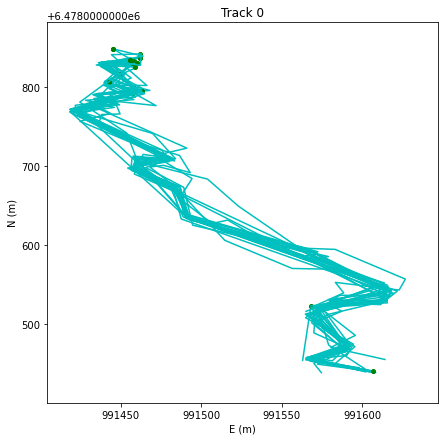

In [5]:
collection2 = tkl.TrackCollection()
for trace in collection:
    SPLITS = tkl.splitReturnTripExhaustive(trace, verbose=False)
    #print (collection4.size())
    t1 = SPLITS[0]
    t2 = SPLITS[1]
    d = tkl.compare(t1, t2, tkl.MODE_COMPARISON_AREAL)

    if d < 5:
        collection2.addTrack(t1)
        collection2.addTrack(t2)

    else:
        # On ne découpe pas
        collection2.addTrack(trace)

TREF = collection2[0]
collection3 = tkl.TrackCollection()
for t in collection2:
    d1 = tkl.compare(TREF, t, verbose=False, mode=tkl.MODE_COMPARISON_DTW, p=1)
    d2 = tkl.compare(TREF, t.reverse(), verbose=False, mode=tkl.MODE_COMPARISON_DTW, p=1)

    # A l'envers
    if (d2 < d1):
        t = t.reverse()
        collection3.addTrack(t)
    else:
        collection3.addTrack(t)

print ('Number of tracks: ', collection3.size())
print 

plt.figure(figsize=(7, 7))
for t in collection3:
    t.plot('c-', append=True)
    t.plotFirstObs(color='g', text='', append=True)

In [6]:
master = tkl.MODE_MASTER_MEDIAN_LEN
represent_method = tkl.MODE_REP_BARYCENTRE
agg_method = tkl.MODE_AGG_MEDIAN
constraint = False

# Aggregation with DTW distance
p = 2
mode = tkl.MODE_MATCHING_DTW
centralDTW = tkl.fusion(collection3,
                     master=master, dim=2,
                     mode=mode, p=p,
                     represent_method=represent_method, 
                     agg_method=agg_method,
                     constraint=constraint, 
                     verbose=False, 
                     iter_max=100)

# Aggregation with Frechet distance
mode = tkl.MODE_MATCHING_FRECHET
p = float('inf')
centralFrechet = tkl.fusion(collection3,
                     master=master, dim=2,
                     mode=mode, p=p,
                     represent_method=represent_method, 
                     agg_method=agg_method,
                     constraint=constraint, 
                     verbose=False, 
                     iter_max=100)

([], [])

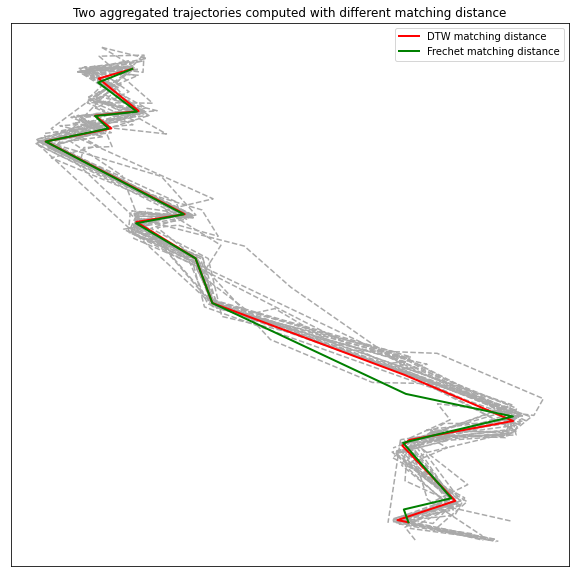

In [7]:
# ----------------------------------------------------------------
#      Plotting results
#
plt.figure(figsize=(10, 10))

for t in collection3:
    plt.plot(t.getX(), t.getY(), color="darkgrey", linestyle='--')

plt.plot(centralDTW.getX(), centralDTW.getY(), 'r-', linewidth=2.0, label='DTW matching distance')
plt.plot(centralFrechet.getX(), centralFrechet.getY(), 'g-', linewidth=2.0, label='Frechet matching distance')

plt.legend()
plt.title('Two aggregated trajectories computed with different matching distance')
plt.xticks([])
plt.yticks([])